# How to tune the parameters of an optimization
**Defining parameters of the optimization using the cost history and early halt conditions**

Boulder Opal provides a highly flexible [optimization engine](https://docs.q-ctrl.com/boulder-opal/topics/choosing-a-control-design-optimization-strategy-in-boulder-opal) for general-purpose optimization.
It can be directly applied to model-based control optimization and for model-based system identification, where the model of the system is represented by an acyclic graph.
You can adjust the parameters in the graph representation to customize many aspects of the optimization, such as the maximum value of the optimizable pulses, and the number of segments used in the optimization.

When tuning the parameters of an optimization, you can use the additional information provided by the history of costs obtained during the course of the optimization to see which choices of these parameters are the best for your purposes.
By halting the optimization before it runs for too long and extracting the histories, you can determine which choices of parameters have values of costs that are still improving in time, and which ones stagnate at a high value.

This user guide will show how to use the cost histories returned by the optimization engine to select the number of segments for a non-stochastic optimization of a large system.
For general instructions about how to perform optimization of a large system, see the user guide [How to optimize controls on large sparse Hamiltonians](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-on-large-sparse-hamiltonians).
For an example of how to use the cost history to tune parameters of a stochastic optimization, see the user guide [How to tune the learning rate of a stochastic optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-tune-the-learning-rate-of-a-stochastic-optimization).

## Summary workflow
### 1. Define a function to create the computational graphs

The Boulder Opal optimization engine expresses all optimization problems as [data flow graphs](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal), which you can create with `boulderopal.Graph`.
The methods of the graph object allow you to represent the mathematical structure of the problem that you want to solve.
You can define a function that creates a graph that represents your system, and which takes the parameter that you want to vary as an argument.

### 2. Execute optimization and retrieve cost history

You can calculate an optimization from an input graph using the functions `boulderopal.run_optimization`, `boulderopal.run_stochastic_optimization`, and `boulderopal.run_gradient_free_optimization`.
Both functions allow you to retrieve the history of all the costs for each step of the optimization, or the history of the best value of the costs up to each iteration.
You can request the history of costs with the `cost_history_scope` argument of these functions.

If you are interested in just testing an optimization that might take a while to finish, you can limit the number of iterations with the parameter `max_iteration_count` (for `boulderopal.run_optimization`) and `iteration_count` (for `boulderopal.run_stochastic_optimization` and `boulderopal.run_gradient_free_optimization`).
This will allow you to retrieve the beginning of the cost history, without spending too much time in the optimization.

### 3. Compare the cost histories for different choices of parameters

You can retrieve the list of costs by extracting the values from the `"cost_history"` element in the dictionary returned by the optimization.
By plotting these results, you can then verify which choices of parameters resulted in costs that stagnated, and which ones kept improving.
You can then keep refining the choices, and requesting more iterations for the parameter values that did not stagnate.

## Example: Tuning the number of segments in an optimization with six Rydberg atoms

Consider a chain of 6 atoms, each one modeled as a qubit, with $|0\rangle$ representing the ground state and $|1\rangle$ representing a Rydberg state.
The total Hamiltonian of the system, is given by

$$ H = \frac{\Omega(t)}{2} \sum_{i=1}^6 \sigma_x^{(i)} - \sum_{i=1}^6 (\Delta(t) +\delta_i) n_i + \sum_{i<j}^6 \frac{V}{\vert i-j \vert^6}n_i n_j , $$

with $\sigma_x^{(i)} = \vert 0 \rangle \langle 1 \vert_i + \vert 1 \rangle \langle 0 \vert_i$, and $n_i = \vert 1\rangle\langle 1 \vert_i$.
The fixed system parameters are the interaction strength between excited atoms, $V$, and the local energy shifts, $\{ \delta_i \}$.
The control parameters are the effective coupling strength to the Rydberg state and the detuning, $\Omega(t)$ and $\Delta(t)$ respectively.

Suppose that you want to use the optimizer to find the best pulses to obtain a GHZ state from an initial ground state, but you don't know which choice for the number of segments will yield the best result.
In this case, you can run the optimization for different values of the number of segments, and retrieve the history of the best cost for each of them.
By plotting these best costs as a function of the iteration, you can then see which choices of the parameters stagnated at a certain value of the cost, and which ones kept improving.
For those that kept improving without stagnating, you can increase the iteration count to obtain better results.

In [1]:
from time import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define optimization parameters.
duration = 1.1e-6  # s
omega_max = 5.0e6 * (2 * np.pi)  # Hz
delta_range = 15.0e6 * (2 * np.pi)  # Hz

# Define physical parameters of the quantum system.
interaction_strength = 24.0e6 * (2 * np.pi)  # Hz
local_shifts = np.zeros((6,))
local_shifts[[0, -1]] = -4.5e6 * (2 * np.pi)  # Hz

In [3]:
# Build the terms of the Hamiltonian.
h_omega_values = [0.5] * 2**6 * 6
h_omega_indices = []
h_delta_values = []
h_delta_indices = []
h_fixed_values = []
h_fixed_indices = []

for j in range(2**6):
    state = np.array([int(m) for m in np.binary_repr(j, width=6)])

    # Global shift term (big delta).
    n_exc = np.sum(state)  # Number of excited atoms.
    h_delta_values.append(-n_exc)
    h_delta_indices.append([j, j])

    # Omega term.
    for i in range(6):
        # Couple "state" and "state with qubit i flipped".
        h_omega_indices.append([j, j ^ 2 ** (5 - i)])

    # Local shift term (small deltas).
    h_fixed = -np.sum(local_shifts * state)

    # Interaction term.
    for d in range(1, 6):
        # Number of excited atoms at distance d.
        n_d = np.dot(((state[:-d] - state[d:]) == 0), state[:-d])
        h_fixed += interaction_strength * n_d / d**6

    if h_fixed != 0.0:
        h_fixed_values.append(h_fixed)
        h_fixed_indices.append([j, j])

H_omega = scipy.sparse.coo_matrix(
    (h_omega_values, np.array(h_omega_indices).T), shape=[2**6, 2**6]
)
H_delta = scipy.sparse.coo_matrix(
    (h_delta_values, np.array(h_delta_indices).T), shape=[2**6, 2**6]
)
H_fixed = scipy.sparse.coo_matrix(
    (h_fixed_values, np.array(h_fixed_indices).T), shape=[2**6, 2**6]
)

In [4]:
def get_recommended_k(segment_count, H_omega, H_delta, H_fixed):
    """
    Calculate the appropriate Krylov subspace dimension (k)
    for a given set of parameters, as required for the integration.
    This is obtained for the Hamiltonian with the largest spectral range.
    """
    graph = bo.Graph()

    maximal_range_hamiltonian = (
        omega_max * H_omega - delta_range * H_delta + H_fixed
    ).tocoo()

    # Calculate spectral range.
    spectral_range = graph.spectral_range(operator=maximal_range_hamiltonian)

    # Calculate the appropriate Krylov subspace dimension k.
    graph.estimated_krylov_subspace_dimension_lanczos(
        spectral_range=spectral_range,
        error_tolerance=1e-6,
        duration=duration,
        maximum_segment_duration=duration / segment_count,
        name="k",
    )

    result = bo.execute_graph(graph=graph, output_node_names="k")

    return result["output"]["k"]["value"]


def get_optimization_graph(segment_count, krylov_subspace_dimension):
    """
    Create an optimization graph for the requested number of segments.
    """
    graph = bo.Graph()

    # Define pulses.
    omega_segments = graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        minimum=0.0,
        maximum=omega_max,
        duration=duration,
        name="omega",
    )
    delta_segments = graph.real_optimizable_pwc_signal(
        segment_count=segment_count,
        minimum=-delta_range,
        maximum=delta_range,
        duration=duration,
        name="delta",
    )
    fixed_segment = graph.pwc_signal(
        values=np.array([1]), duration=duration, name="fixed"
    )

    shift_delta = graph.sparse_pwc_operator(signal=delta_segments, operator=H_delta)
    shift_omega = graph.sparse_pwc_operator(signal=omega_segments, operator=H_omega)
    shift_fixed = graph.sparse_pwc_operator(signal=fixed_segment, operator=H_fixed)

    # Define initial state
    initial_state = graph.fock_state(2**6, 0)

    # Create target state.
    idx_even = sum(2**n for n in range(0, 6, 2))
    idx_odd = sum(2**n for n in range(1, 6, 2))
    target_state = np.zeros([2**6])
    target_state[[idx_even, idx_odd]] = 1.0 / np.sqrt(2.0)

    # Evolve the initial state.
    evolved_state = graph.state_evolution_pwc(
        initial_state=initial_state,
        hamiltonian=graph.sparse_pwc_sum([shift_fixed, shift_omega, shift_delta]),
        krylov_subspace_dimension=krylov_subspace_dimension,
    )

    # Calculate state infidelity.
    infidelity = graph.state_infidelity(target_state, evolved_state, name="infidelity")

    return graph

In [5]:
results = {}
segment_counts = [2**n for n in range(4, 10)]
calculation_times = []

# Run optimizations.
for segment_count in segment_counts:
    krylov_subspace_dimension = get_recommended_k(
        segment_count, H_omega, H_delta, H_fixed
    )
    graph = get_optimization_graph(segment_count, krylov_subspace_dimension)
    time_reference = time()
    results[segment_count] = bo.run_optimization(
        graph=graph,
        cost_node_name="infidelity",
        output_node_names=["infidelity"],
        optimization_count=1,
        max_iteration_count=300,
        cost_history_scope="HISTORICAL_BEST",
    )
    calculation_times.append(time() - time_reference)

Your task (action_id="1829167") is queued.
Your task (action_id="1829167") has completed.
Your task (action_id="1829168") has started.
Your task (action_id="1829168") has completed.
Your task (action_id="1829169") has started.
Your task (action_id="1829169") has completed.
Your task (action_id="1829170") has started.
Your task (action_id="1829170") has completed.
Your task (action_id="1829171") has started.
Your task (action_id="1829171") has completed.
Your task (action_id="1829172") has started.
Your task (action_id="1829172") has completed.
Your task (action_id="1829173") has started.
Your task (action_id="1829173") has completed.
Your task (action_id="1829174") has started.
Your task (action_id="1829174") has completed.
Your task (action_id="1829177") has started.
Your task (action_id="1829177") has completed.
Your task (action_id="1829178") has started.
Your task (action_id="1829178") has completed.
Your task (action_id="1829179") has started.
Your task (action_id="1829179") has c

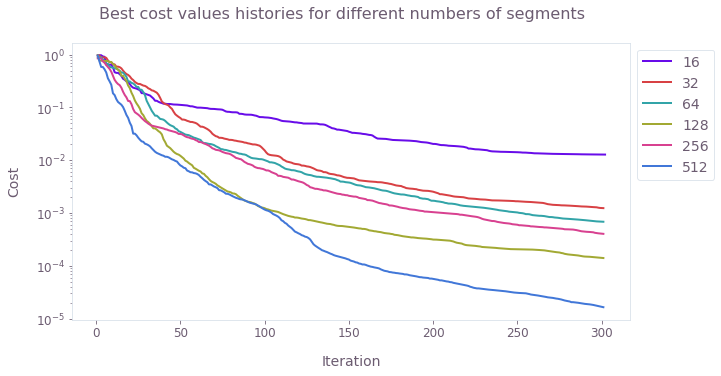

In [6]:
# Plot history of best costs.
qv.plot_cost_histories(
    [
        result["cost_history"]["historical_best"][0]
        for segment_count, result in results.items()
    ],
    labels=[str(n) for n in segment_counts],
    y_axis_log=True,
)
plt.suptitle("Best cost values histories for different numbers of segments")
plt.show()

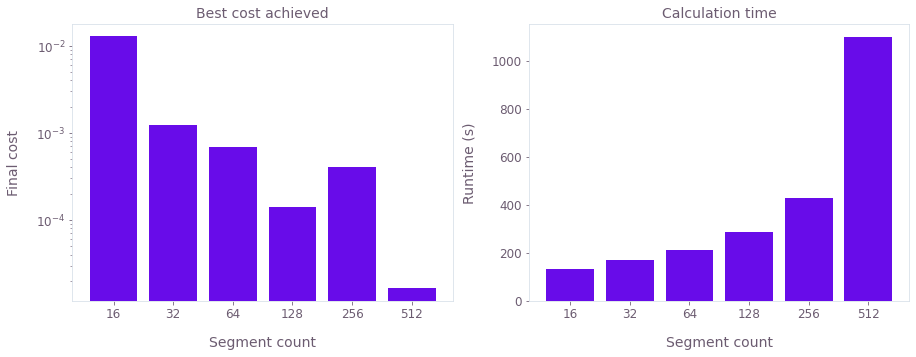

In [7]:
# Plot final costs and calculation times.

costs = [result["cost"] for result in results.values()]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
labels = [str(s) for s in segment_counts]
axes[0].bar(labels, costs, log=True)
axes[1].bar(labels, calculation_times)

axes[0].set_title("Best cost achieved")
axes[0].set_xlabel("Segment count")
axes[0].set_ylabel("Final cost")

axes[1].set_title("Calculation time")
axes[1].set_xlabel("Segment count")
axes[1].set_ylabel("Runtime (s)")

plt.show()